# Project tryout: different algorithms

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


First level of complexity: averaging over the four next nearest neighbors (1st/0th order diffusion?). 
Second level of complexity: 2nd order diffusion, applying the laplacian function once.
Third level of complexity: 4th order diffusion, applying the laplacian twice.

In [3]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

In [29]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=complexity-0
make VERSION=complexity-1
make VERSION=complexity-1-nnn
make VERSION=complexity-copy
make VERSION=kblocking

make: 'stencil2d-complexity-0.x' is up to date.
make: 'stencil2d-complexity-1.x' is up to date.
make: 'stencil2d-complexity-1-nnn.x' is up to date.
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-complexity-copy.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-complexity-copy.o -o stencil2d-complexity-copy.x
cp stencil2d-complexity-copy.x stencil2d.x
make: 'stencil2d-kblocking.x' is up to date.


In [16]:
%%bash
srun -n 12 ./stencil2d-kblocking.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.1080225E+01], \
] )


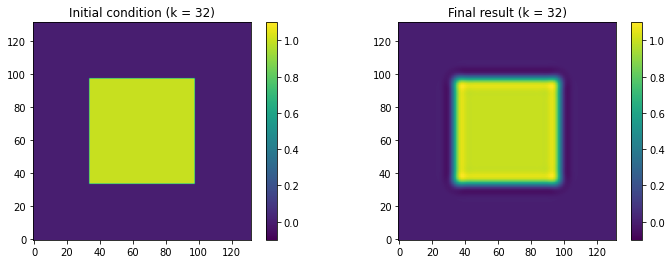

In [17]:
validate_results()

In [18]:
%%bash
srun -n 12 ./stencil2d-complexity-0.x --nx 128 --ny 128 --nz 64 --num_iter 128

srun: Job 54678752 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 54678752


# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.8274553E+00], \
] )


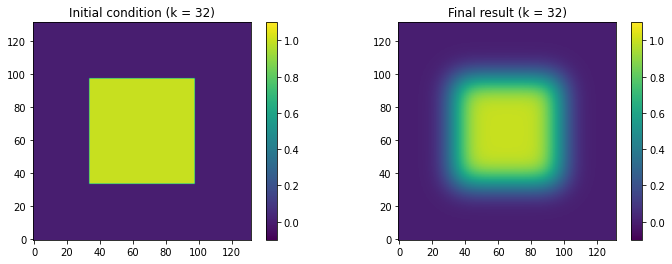

In [19]:
validate_results()

In [20]:
%%bash
srun -n 12 ./stencil2d-complexity-1.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.8278053E+00], \
] )


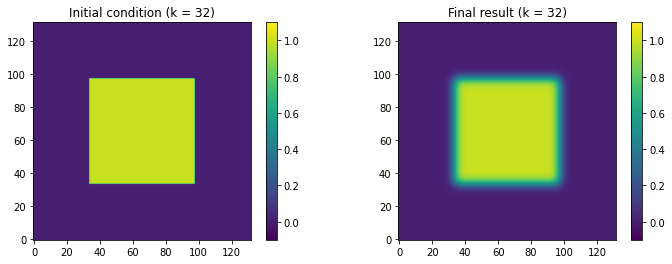

In [21]:
validate_results()

In [25]:
%%bash
srun -n 12 ./stencil2d-complexity-1-nnn.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.8101660E+00], \
] )


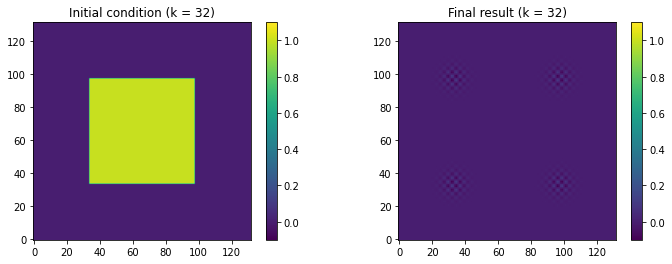

In [26]:
validate_results()

In [30]:
%%bash
srun -n 12 ./stencil2d-complexity-copy.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.8217698E+00], \
] )


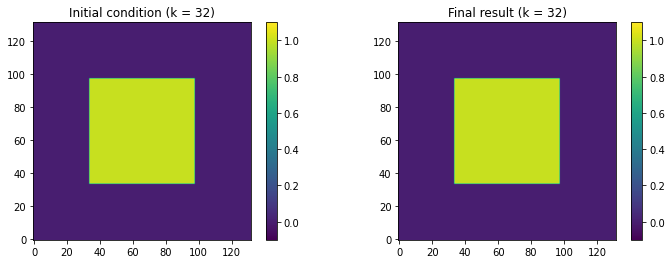

In [31]:
validate_results()